Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Number of columns: 22
Number of rows: 70692
Column names: Index(['Diabetes_binary', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')
Missing Values:
 Diabetes_binary         0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk         

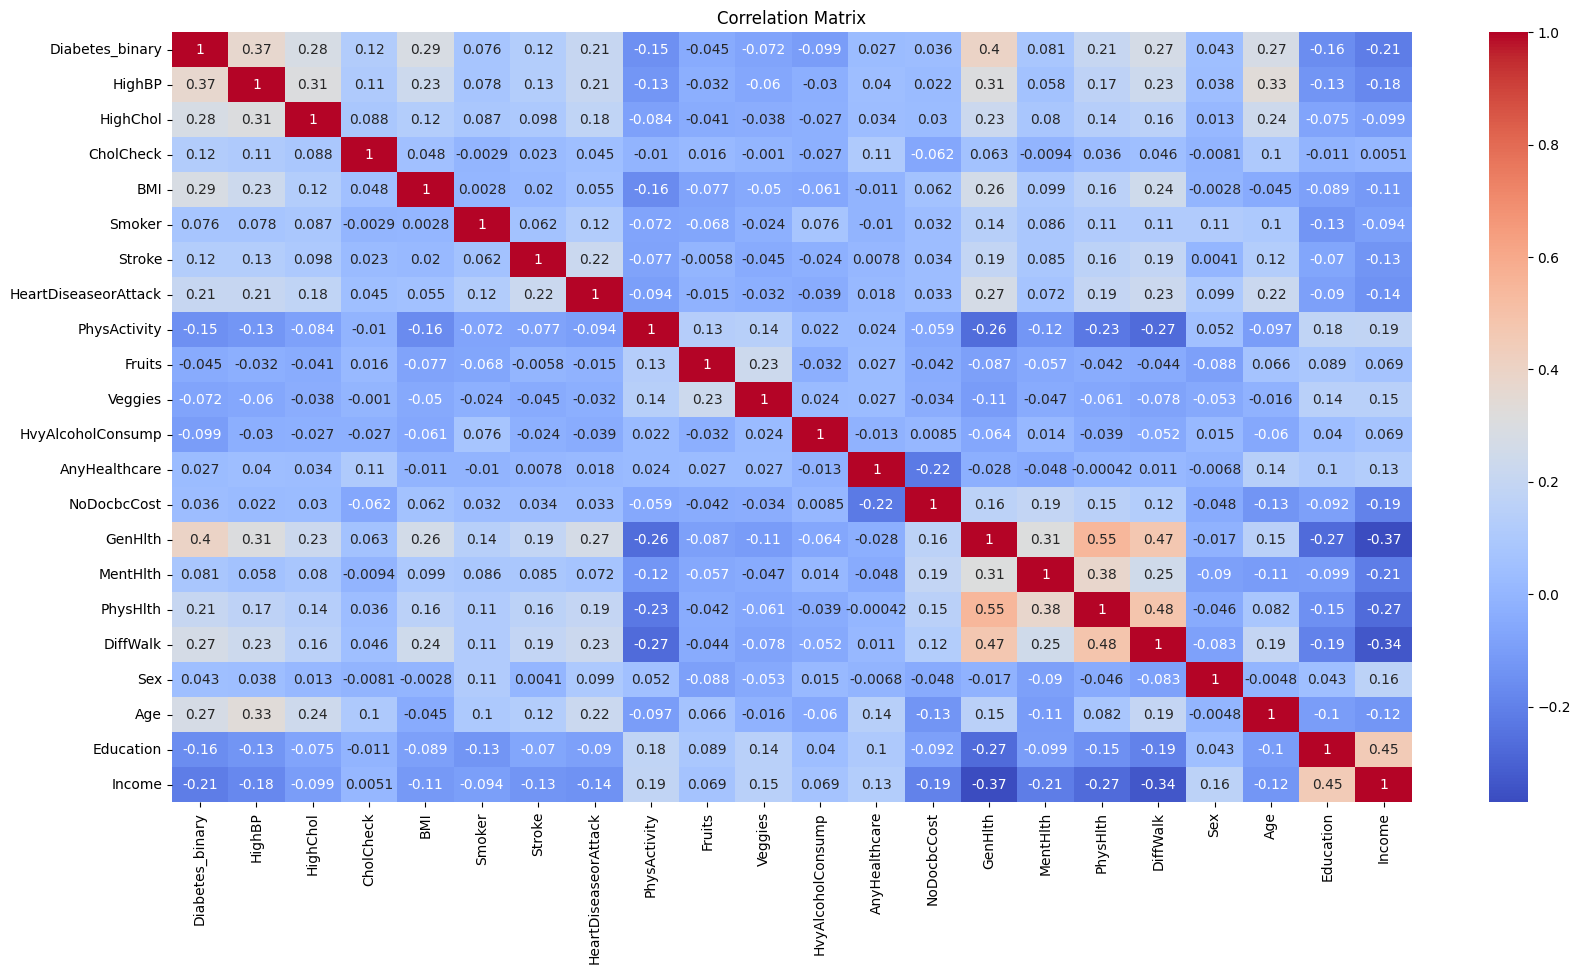

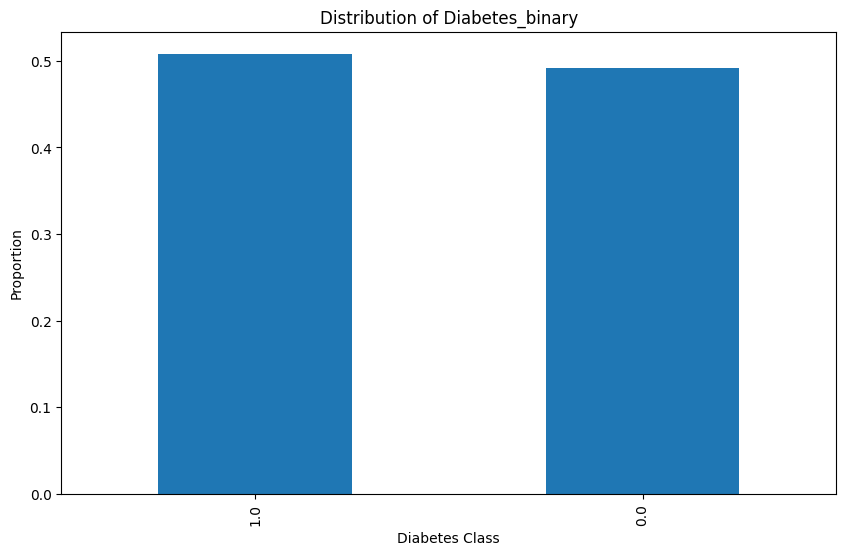

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, regularizers, callbacks, models, optimizers


from google.colab import drive
drive.mount('/content/drive')

# Load the dataset
file_path = '/content/diabetes_binary_5050split_health_indicators_BRFSS2015.csv'
df = pd.read_csv(file_path)

# How many columns does the dataset contain?
columns = df.shape[1]
print("Number of columns:", columns)

# How many rows are there in the dataset?
rows = df.shape[0]
print("Number of rows:", rows)

# What are the column names?
names = df.columns
print("Column names:", names)

# Check if Missing Values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

# Check if Duplicating Values
duplicating_values = df.duplicated().sum()
print("Number of duplicate rows:", duplicating_values)

# Drop Duplicating Values
df = df.drop_duplicates()

# Create Coorelation Matrix of Outcome and Feature Variables
cm = df.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(cm.values, annot=True, cmap='coolwarm', xticklabels=cm.columns, yticklabels=cm.columns)
plt.title("Correlation Matrix")
plt.show()

# Select Features Based on Correlation Matrix
selected_features = ['HighBP', 'HighChol', 'BMI', 'GenHlth', 'DiffWalk', 'Age', 'Income']

# Set Up Features of Interest
X = df[selected_features]

# Set Up Outcome of Interest
y = df['Diabetes_binary']

# Check of Outcome of Interest is Balanced
plt.figure(figsize=(10, 6))
y.value_counts(normalize=True).plot(kind='bar')
plt.title('Distribution of Diabetes_binary')
plt.xlabel('Diabetes Class')
plt.ylabel('Proportion')
plt.show()

tf.random.set_seed(1234)
np.random.seed(1234)

# Shuffle Data
shuffled_indices = np.random.permutation(len(X))
X = X.iloc[shuffled_indices]
y = y.iloc[shuffled_indices]

# Create Data Splits
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=1234)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1234)

# Data Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Logistic Regression Training Accuracy: 0.7391
Logistic Regression Validation Accuracy: 0.7467
Logistic Regression Test Accuracy: 0.7320


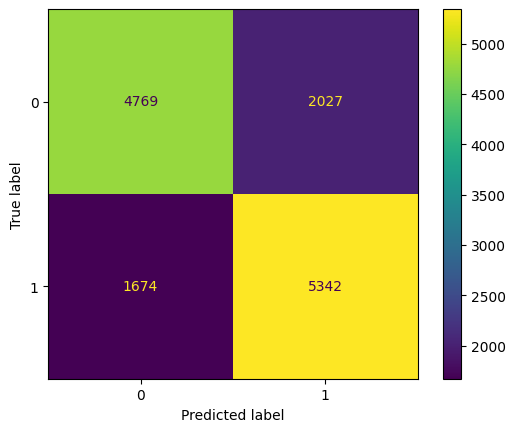

TP: 5342
FN: 1674
FP: 2027
TN: 4769
Diabetic Accuracy: 0.7614
Non-Diabetic Accuracy: 0.7017


In [86]:
# Baseline Model: Logistic Regression

# Initate Logistic Regression Model
log_reg = LogisticRegression()

# Training the model w/ training set
log_reg.fit(X_train_scaled, y_train)

# Evaluate & Print Training Accuracy
y_pred_train_log = log_reg.predict(X_train_scaled)
train_accuracy_log = accuracy_score(y_train, y_pred_train_log)
print(f'Logistic Regression Training Accuracy: {train_accuracy_log:.4f}')

# Generate predictions on the validation set
y_pred_val_log = log_reg.predict(X_val_scaled)
val_accuracy_log = accuracy_score(y_val, y_pred_val_log)
print(f'Logistic Regression Validation Accuracy: {val_accuracy_log:.4f}')

# Generate predictions on the test set
y_pred_test_log = log_reg.predict(X_test_scaled)
test_accuracy_log = accuracy_score(y_test, y_pred_test_log)
print(f'Logistic Regression Test Accuracy: {test_accuracy_log:.4f}')

# Generate confusion matrix on the test set
cm = confusion_matrix(y_test, y_pred_test_log)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# TP FN FP TN
print("TP:", cm[1, 1])
print("FN:", cm[1, 0])
print("FP:", cm[0, 1])
print("TN:", cm[0, 0])

# Compute subgroup accuracy
diabetic_accuracy = cm[1, 1] / (cm[1, 1] + cm[1, 0])
non_diabetic_accuracy = cm[0, 0] / (cm[0, 0] + cm[0, 1])

print(f'Diabetic Accuracy: {diabetic_accuracy:.4f}')
print(f'Non-Diabetic Accuracy: {non_diabetic_accuracy:.4f}')

In [52]:
# Improved Model: Neural Network
def train_and_evaluate(hidden_1,
                       hidden_2,
                       activation,
                       dropout_1,
                       dropout_2,
                       optimizer_name,
                       epochs,
                       batch_size,
                       learning_rate):

    # clear session
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)
    np.random.seed(1234)

    # Define the model
    model = keras.models.Sequential()

    # Input Layer
    model.add(layers.Input(shape=(X_train.shape[1],)))

    # First Hidden Layer
    model.add(layers.Dense(hidden_1, activation=activation))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_1))

    # Second Hidden Layer
    model.add(layers.Dense(hidden_2, activation=activation, kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_2))

    # Output Layer
    model.add(layers.Dense(1, activation='sigmoid'))

    # build and compile model
    optimizer = getattr(keras.optimizers, optimizer_name)(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # define an instance of the early_stopping class
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)

    # train model on (X_train_scaled, y_train) data
    model_fit = model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], validation_data=(X_val_scaled, y_val))

    # print model summary
    model.summary()

    # evaluate the accuracy on training set and validation set
    train_loss, train_accuracy = model.evaluate(X_train_scaled, y_train)
    val_loss, val_accuracy = model.evaluate(X_val_scaled, y_val)
    print(f'Training Accuracy: {train_accuracy:.4f}')
    print(f'Validation Accuracy: {val_accuracy:.4f}')

    return model, model_fit


In [54]:
model1, model_fit1 = train_and_evaluate(hidden_1 = 64,
                       hidden_2 = 32,
                       activation = 'relu',
                       dropout_1 = 0.5,
                       dropout_2 = 0.3,
                       optimizer_name = 'SGD',
                       epochs = 200,
                       batch_size = 64,
                       learning_rate = 0.001)

Epoch 1/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5375 - loss: 1.2857 - val_accuracy: 0.6921 - val_loss: 0.9960
Epoch 2/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6437 - loss: 1.0894 - val_accuracy: 0.7241 - val_loss: 0.9512
Epoch 3/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6729 - loss: 1.0370 - val_accuracy: 0.7329 - val_loss: 0.9283
Epoch 4/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6870 - loss: 1.0079 - val_accuracy: 0.7373 - val_loss: 0.9126
Epoch 5/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6957 - loss: 0.9802 - val_accuracy: 0.7417 - val_loss: 0.8995
Epoch 6/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6990 - loss: 0.9590 - val_accuracy: 0.7436 - val_loss: 0.8878
Epoch 7/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7044 - loss: 0.9434 - val_accuracy: 0.7445 - val_loss: 0.8773
Epoch 8/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7095 - loss: 0.9321 - val_accu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,011 (11.77 KB)

 Trainable params: 2,817 (11.00 KB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 2 (12.00 B)

1295/1295 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7396 - loss: 0.6880
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7492 - loss: 0.6807
Training Accuracy: 0.7423
Validation Accuracy: 0.7496


In [55]:
model2, model_fit2 = train_and_evaluate(hidden_1 = 64,
                       hidden_2 = 32,
                       activation = 'relu',
                       dropout_1 = 0.5,
                       dropout_2 = 0.3,
                       optimizer_name = 'Adam',
                       epochs = 200,
                       batch_size = 64,
                       learning_rate = 0.001)

Epoch 1/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6803 - loss: 0.8711 - val_accuracy: 0.7480 - val_loss: 0.5674
Epoch 2/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7303 - loss: 0.5784 - val_accuracy: 0.7498 - val_loss: 0.5267
Epoch 3/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7375 - loss: 0.5443 - val_accuracy: 0.7477 - val_loss: 0.5208
Epoch 4/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7354 - loss: 0.5382 - val_accuracy: 0.7474 - val_loss: 0.5191
Epoch 5/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7360 - loss: 0.5379 - val_accuracy: 0.7484 - val_loss: 0.5177
Epoch 6/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7370 - loss: 0.5357 - val_accuracy: 0.7472 - val_loss: 0.5186
Epoch 7/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7376 - loss: 0.5349 - val_accuracy: 0.7473 - val_loss: 0.5170
Epoch 8/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7374 - loss: 0.5348 - val_accu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,645 (33.77 KB)

 Trainable params: 2,817 (11.00 KB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 5,636 (22.02 KB)

1295/1295 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7411 - loss: 0.5358
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7478 - loss: 0.5285
Training Accuracy: 0.7437
Validation Accuracy: 0.7498


In [56]:
model3, model_fit3 = train_and_evaluate(hidden_1 = 64,
                       hidden_2 = 32,
                       activation = 'tanh',
                       dropout_1 = 0.5,
                       dropout_2 = 0.3,
                       optimizer_name = 'SGD',
                       epochs = 200,
                       batch_size = 64,
                       learning_rate = 0.001)

Epoch 1/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5784 - loss: 1.2133 - val_accuracy: 0.7424 - val_loss: 0.9436
Epoch 2/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6804 - loss: 1.0499 - val_accuracy: 0.7459 - val_loss: 0.9328
Epoch 3/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6889 - loss: 1.0205 - val_accuracy: 0.7473 - val_loss: 0.9197
Epoch 4/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7047 - loss: 0.9851 - val_accuracy: 0.7461 - val_loss: 0.9056
Epoch 5/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7030 - loss: 0.9644 - val_accuracy: 0.7466 - val_loss: 0.8934
Epoch 6/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7105 - loss: 0.9449 - val_accuracy: 0.7469 - val_loss: 0.8815
Epoch 7/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7077 - loss: 0.9327 - val_accuracy: 0.7471 - val_loss: 0.8711
Epoch 8/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7158 - loss: 0.9142 - val_accu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,011 (11.77 KB)

 Trainable params: 2,817 (11.00 KB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 2 (12.00 B)

1295/1295 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7362 - loss: 0.9324
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7454 - loss: 0.9220
Training Accuracy: 0.7377
Validation Accuracy: 0.7473


In [57]:
model4, model_fit4 = train_and_evaluate(hidden_1 = 64,
                       hidden_2 = 32,
                       activation = 'tanh',
                       dropout_1 = 0.5,
                       dropout_2 = 0.3,
                       optimizer_name = 'Adam',
                       epochs = 200,
                       batch_size = 64,
                       learning_rate = 0.001)

Epoch 1/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6864 - loss: 0.9097 - val_accuracy: 0.7487 - val_loss: 0.5812
Epoch 2/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7297 - loss: 0.5905 - val_accuracy: 0.7472 - val_loss: 0.5314
Epoch 3/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7308 - loss: 0.5461 - val_accuracy: 0.7474 - val_loss: 0.5217
Epoch 4/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7360 - loss: 0.5384 - val_accuracy: 0.7466 - val_loss: 0.5199
Epoch 5/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7372 - loss: 0.5360 - val_accuracy: 0.7480 - val_loss: 0.5199
Epoch 6/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7359 - loss: 0.5337 - val_accuracy: 0.7481 - val_loss: 0.5184
Epoch 7/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7361 - loss: 0.5332 - val_accuracy: 0.7461 - val_loss: 0.5181
Epoch 8/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7378 - loss: 0.5337 - val_accu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,645 (33.77 KB)

 Trainable params: 2,817 (11.00 KB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 5,636 (22.02 KB)

1295/1295 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7381 - loss: 0.5906
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7453 - loss: 0.5823
Training Accuracy: 0.7397
Validation Accuracy: 0.7487


In [58]:
model5, model_fit5 = train_and_evaluate(hidden_1 = 128,
                       hidden_2 = 64,
                       activation = 'relu',
                       dropout_1 = 0.5,
                       dropout_2 = 0.3,
                       optimizer_name = 'SGD',
                       epochs = 200,
                       batch_size = 64,
                       learning_rate = 0.001)

Epoch 1/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5895 - loss: 1.6394 - val_accuracy: 0.7356 - val_loss: 1.3611
Epoch 2/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6809 - loss: 1.4804 - val_accuracy: 0.7448 - val_loss: 1.3262
Epoch 3/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6950 - loss: 1.4219 - val_accuracy: 0.7469 - val_loss: 1.2985
Epoch 4/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6987 - loss: 1.3855 - val_accuracy: 0.7482 - val_loss: 1.2753
Epoch 5/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7030 - loss: 1.3543 - val_accuracy: 0.7488 - val_loss: 1.2540
Epoch 6/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7114 - loss: 1.3202 - val_accuracy: 0.7487 - val_loss: 1.2340
Epoch 7/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7100 - loss: 1.2951 - val_accuracy: 0.7495 - val_loss: 1.2150
Epoch 8/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7139 - loss: 1.2667 - val_accu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,115 (39.52 KB)

 Trainable params: 9,729 (38.00 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 2 (12.00 B)

1295/1295 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7388 - loss: 1.2077
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7474 - loss: 1.1993
Training Accuracy: 0.7407
Validation Accuracy: 0.7509


In [59]:
model6, model_fit6 = train_and_evaluate(hidden_1 = 128,
                       hidden_2 = 64,
                       activation = 'relu',
                       dropout_1 = 0.5,
                       dropout_2 = 0.3,
                       optimizer_name = 'Adam',
                       epochs = 200,
                       batch_size = 64,
                       learning_rate = 0.001)

Epoch 1/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.6956 - loss: 1.1495 - val_accuracy: 0.7474 - val_loss: 0.6094
Epoch 2/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7328 - loss: 0.6016 - val_accuracy: 0.7474 - val_loss: 0.5307
Epoch 3/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7360 - loss: 0.5469 - val_accuracy: 0.7501 - val_loss: 0.5219
Epoch 4/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7337 - loss: 0.5395 - val_accuracy: 0.7485 - val_loss: 0.5210
Epoch 5/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7367 - loss: 0.5390 - val_accuracy: 0.7488 - val_loss: 0.5199
Epoch 6/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7362 - loss: 0.5369 - val_accuracy: 0.7514 - val_loss: 0.5200
Epoch 7/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7368 - loss: 0.5354 - val_accuracy: 0.7498 - val_loss: 0.5192
Epoch 8/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7360 - loss: 0.5369 - val_accu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,573 (115.52 KB)

 Trainable params: 9,729 (38.00 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 19,460 (76.02 KB)

1295/1295 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7427 - loss: 0.5292
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7508 - loss: 0.5216
Training Accuracy: 0.7442
Validation Accuracy: 0.7514


In [60]:
model7, model_fit7 = train_and_evaluate(hidden_1 = 128,
                       hidden_2 = 64,
                       activation = 'tanh',
                       dropout_1 = 0.5,
                       dropout_2 = 0.3,
                       optimizer_name = 'SGD',
                       epochs = 200,
                       batch_size = 64,
                       learning_rate = 0.001)

Epoch 1/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5959 - loss: 1.6332 - val_accuracy: 0.7396 - val_loss: 1.3707
Epoch 2/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6857 - loss: 1.4645 - val_accuracy: 0.7431 - val_loss: 1.3441
Epoch 3/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6961 - loss: 1.4188 - val_accuracy: 0.7434 - val_loss: 1.3171
Epoch 4/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7004 - loss: 1.3792 - val_accuracy: 0.7438 - val_loss: 1.2936
Epoch 5/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7013 - loss: 1.3529 - val_accuracy: 0.7446 - val_loss: 1.2709
Epoch 6/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7082 - loss: 1.3143 - val_accuracy: 0.7435 - val_loss: 1.2494
Epoch 7/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7103 - loss: 1.2907 - val_accuracy: 0.7442 - val_loss: 1.2294
Epoch 8/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7131 - loss: 1.2720 - val_accu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,115 (39.52 KB)

 Trainable params: 9,729 (38.00 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 2 (12.00 B)

1295/1295 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7389 - loss: 0.8422
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7456 - loss: 0.8341
Training Accuracy: 0.7393
Validation Accuracy: 0.7485


In [61]:
model8, model_fit8 = train_and_evaluate(hidden_1 = 128,
                       hidden_2 = 64,
                       activation = 'tanh',
                       dropout_1 = 0.5,
                       dropout_2 = 0.3,
                       optimizer_name = 'Adam',
                       epochs = 200,
                       batch_size = 64,
                       learning_rate = 0.001)

Epoch 1/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6950 - loss: 1.1169 - val_accuracy: 0.7474 - val_loss: 0.5979
Epoch 2/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7320 - loss: 0.5916 - val_accuracy: 0.7477 - val_loss: 0.5294
Epoch 3/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7337 - loss: 0.5429 - val_accuracy: 0.7480 - val_loss: 0.5224
Epoch 4/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7367 - loss: 0.5375 - val_accuracy: 0.7473 - val_loss: 0.5221
Epoch 5/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7336 - loss: 0.5372 - val_accuracy: 0.7472 - val_loss: 0.5209
Epoch 6/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7359 - loss: 0.5353 - val_accuracy: 0.7479 - val_loss: 0.5204
Epoch 7/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7369 - loss: 0.5354 - val_accuracy: 0.7480 - val_loss: 0.5197
Epoch 8/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7372 - loss: 0.5351 - val_accu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,573 (115.52 KB)

 Trainable params: 9,729 (38.00 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 19,460 (76.02 KB)

1295/1295 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7409 - loss: 0.5276
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7472 - loss: 0.5192
Training Accuracy: 0.7437
Validation Accuracy: 0.7498


In [62]:
model9, model_fit9 = train_and_evaluate(hidden_1 = 128,
                       hidden_2 = 64,
                       activation = 'relu',
                       dropout_1 = 0.3,
                       dropout_2 = 0.3,
                       optimizer_name = 'Adam',
                       epochs = 200,
                       batch_size = 64,
                       learning_rate = 0.001)

Epoch 1/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6966 - loss: 1.1134 - val_accuracy: 0.7480 - val_loss: 0.5921
Epoch 2/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7349 - loss: 0.5872 - val_accuracy: 0.7486 - val_loss: 0.5283
Epoch 3/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7356 - loss: 0.5406 - val_accuracy: 0.7495 - val_loss: 0.5207
Epoch 4/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7359 - loss: 0.5371 - val_accuracy: 0.7499 - val_loss: 0.5209
Epoch 5/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7387 - loss: 0.5354 - val_accuracy: 0.7485 - val_loss: 0.5199
Epoch 6/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7391 - loss: 0.5330 - val_accuracy: 0.7486 - val_loss: 0.5184
Epoch 7/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7377 - loss: 0.5349 - val_accuracy: 0.7474 - val_loss: 0.5187
Epoch 8/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7380 - loss: 0.5327 - val_accu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,573 (115.52 KB)

 Trainable params: 9,729 (38.00 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 19,460 (76.02 KB)

1295/1295 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7402 - loss: 0.5305
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7478 - loss: 0.5226
Training Accuracy: 0.7422
Validation Accuracy: 0.7499


In [63]:
model10, model_fit10 = train_and_evaluate(hidden_1 = 128,
                       hidden_2 = 64,
                       activation = 'relu',
                       dropout_1 = 0.4,
                       dropout_2 = 0.4,
                       optimizer_name = 'Adam',
                       epochs = 200,
                       batch_size = 64,
                       learning_rate = 0.001)

Epoch 1/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.6969 - loss: 1.1041 - val_accuracy: 0.7469 - val_loss: 0.5884
Epoch 2/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7349 - loss: 0.5807 - val_accuracy: 0.7497 - val_loss: 0.5273
Epoch 3/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7361 - loss: 0.5426 - val_accuracy: 0.7488 - val_loss: 0.5211
Epoch 4/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7384 - loss: 0.5385 - val_accuracy: 0.7479 - val_loss: 0.5201
Epoch 5/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7365 - loss: 0.5379 - val_accuracy: 0.7500 - val_loss: 0.5204
Epoch 6/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7379 - loss: 0.5363 - val_accuracy: 0.7501 - val_loss: 0.5194
Epoch 7/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7378 - loss: 0.5368 - val_accuracy: 0.7484 - val_loss: 0.5188
Epoch 8/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7398 - loss: 0.5352 - val_accu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,573 (115.52 KB)

 Trainable params: 9,729 (38.00 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 19,460 (76.02 KB)

1295/1295 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7440 - loss: 0.5280
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7495 - loss: 0.5205
Training Accuracy: 0.7449
Validation Accuracy: 0.7505


In [64]:
model11, model_fit11 = train_and_evaluate(hidden_1 = 128,
                       hidden_2 = 64,
                       activation = 'relu',
                       dropout_1 = 0.5,
                       dropout_2 = 0.5,
                       optimizer_name = 'Adam',
                       epochs = 200,
                       batch_size = 64,
                       learning_rate = 0.001)

Epoch 1/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.6885 - loss: 1.1937 - val_accuracy: 0.7485 - val_loss: 0.6097
Epoch 2/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7298 - loss: 0.6007 - val_accuracy: 0.7470 - val_loss: 0.5314
Epoch 3/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7353 - loss: 0.5482 - val_accuracy: 0.7492 - val_loss: 0.5234
Epoch 4/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7354 - loss: 0.5419 - val_accuracy: 0.7482 - val_loss: 0.5230
Epoch 5/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7390 - loss: 0.5417 - val_accuracy: 0.7485 - val_loss: 0.5217
Epoch 6/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7376 - loss: 0.5400 - val_accuracy: 0.7461 - val_loss: 0.5222
Epoch 7/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7366 - loss: 0.5407 - val_accuracy: 0.7476 - val_loss: 0.5222
Epoch 8/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7395 - loss: 0.5383 - val_accu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,573 (115.52 KB)

 Trainable params: 9,729 (38.00 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 19,460 (76.02 KB)

1295/1295 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7428 - loss: 0.5290
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7483 - loss: 0.5215
Training Accuracy: 0.7438
Validation Accuracy: 0.7499


In [65]:
model12, model_fit12 = train_and_evaluate(hidden_1 = 128,
                       hidden_2 = 64,
                       activation = 'relu',
                       dropout_1 = 0.4,
                       dropout_2 = 0.3,
                       optimizer_name = 'Adam',
                       epochs = 200,
                       batch_size = 64,
                       learning_rate = 0.001)

Epoch 1/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6980 - loss: 1.1125 - val_accuracy: 0.7472 - val_loss: 0.5971
Epoch 2/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7333 - loss: 0.5899 - val_accuracy: 0.7500 - val_loss: 0.5266
Epoch 3/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7354 - loss: 0.5415 - val_accuracy: 0.7492 - val_loss: 0.5204
Epoch 4/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7367 - loss: 0.5371 - val_accuracy: 0.7485 - val_loss: 0.5193
Epoch 5/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7361 - loss: 0.5352 - val_accuracy: 0.7482 - val_loss: 0.5194
Epoch 6/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7376 - loss: 0.5353 - val_accuracy: 0.7488 - val_loss: 0.5198
Epoch 7/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7397 - loss: 0.5353 - val_accuracy: 0.7501 - val_loss: 0.5182
Epoch 8/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7397 - loss: 0.5348 - val_accu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,573 (115.52 KB)

 Trainable params: 9,729 (38.00 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 19,460 (76.02 KB)

1295/1295 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7425 - loss: 0.5264
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7501 - loss: 0.5176
Training Accuracy: 0.7443
Validation Accuracy: 0.7509


In [66]:
model13, model_fit13 = train_and_evaluate(hidden_1 = 128,
                       hidden_2 = 64,
                       activation = 'relu',
                       dropout_1 = 0.3,
                       dropout_2 = 0.4,
                       optimizer_name = 'Adam',
                       epochs = 200,
                       batch_size = 64,
                       learning_rate = 0.001)

Epoch 1/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6917 - loss: 1.1672 - val_accuracy: 0.7469 - val_loss: 0.6042
Epoch 2/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7306 - loss: 0.5969 - val_accuracy: 0.7480 - val_loss: 0.5282
Epoch 3/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7358 - loss: 0.5420 - val_accuracy: 0.7490 - val_loss: 0.5203
Epoch 4/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7346 - loss: 0.5380 - val_accuracy: 0.7484 - val_loss: 0.5200
Epoch 5/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7378 - loss: 0.5354 - val_accuracy: 0.7488 - val_loss: 0.5197
Epoch 6/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7394 - loss: 0.5364 - val_accuracy: 0.7478 - val_loss: 0.5194
Epoch 7/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7366 - loss: 0.5355 - val_accuracy: 0.7488 - val_loss: 0.5198
Epoch 8/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7357 - loss: 0.5352 - val_accu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,573 (115.52 KB)

 Trainable params: 9,729 (38.00 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 19,460 (76.02 KB)

1295/1295 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7435 - loss: 0.5276
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7517 - loss: 0.5199
Training Accuracy: 0.7445
Validation Accuracy: 0.7511


In [67]:
model14, model_fit14 = train_and_evaluate(hidden_1 = 128,
                       hidden_2 = 64,
                       activation = 'relu',
                       dropout_1 = 0.3,
                       dropout_2 = 0.5,
                       optimizer_name = 'Adam',
                       epochs = 200,
                       batch_size = 64,
                       learning_rate = 0.001)

Epoch 1/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6933 - loss: 1.1431 - val_accuracy: 0.7480 - val_loss: 0.5971
Epoch 2/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7323 - loss: 0.5901 - val_accuracy: 0.7482 - val_loss: 0.5264
Epoch 3/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7374 - loss: 0.5422 - val_accuracy: 0.7490 - val_loss: 0.5212
Epoch 4/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7351 - loss: 0.5391 - val_accuracy: 0.7493 - val_loss: 0.5205
Epoch 5/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7378 - loss: 0.5385 - val_accuracy: 0.7486 - val_loss: 0.5206
Epoch 6/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7382 - loss: 0.5376 - val_accuracy: 0.7488 - val_loss: 0.5206
Epoch 7/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7385 - loss: 0.5382 - val_accuracy: 0.7488 - val_loss: 0.5200
Epoch 8/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7374 - loss: 0.5369 - val_accu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,573 (115.52 KB)

 Trainable params: 9,729 (38.00 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 19,460 (76.02 KB)

1295/1295 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7426 - loss: 0.5289
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7524 - loss: 0.5202
Training Accuracy: 0.7445
Validation Accuracy: 0.7512


In [68]:
model15, model_fit15 = train_and_evaluate(hidden_1 = 128,
                       hidden_2 = 64,
                       activation = 'relu',
                       dropout_1 = 0.4,
                       dropout_2 = 0.5,
                       optimizer_name = 'Adam',
                       epochs = 200,
                       batch_size = 64,
                       learning_rate = 0.001)

Epoch 1/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6874 - loss: 1.1789 - val_accuracy: 0.7483 - val_loss: 0.6045
Epoch 2/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7330 - loss: 0.5965 - val_accuracy: 0.7487 - val_loss: 0.5291
Epoch 3/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7367 - loss: 0.5459 - val_accuracy: 0.7498 - val_loss: 0.5235
Epoch 4/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7370 - loss: 0.5408 - val_accuracy: 0.7489 - val_loss: 0.5216
Epoch 5/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7366 - loss: 0.5388 - val_accuracy: 0.7493 - val_loss: 0.5219
Epoch 6/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7385 - loss: 0.5379 - val_accuracy: 0.7504 - val_loss: 0.5205
Epoch 7/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7390 - loss: 0.5376 - val_accuracy: 0.7480 - val_loss: 0.5204
Epoch 8/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7371 - loss: 0.5378 - val_accu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,573 (115.52 KB)

 Trainable params: 9,729 (38.00 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 19,460 (76.02 KB)

1295/1295 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7428 - loss: 0.5292
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7504 - loss: 0.5204
Training Accuracy: 0.7445
Validation Accuracy: 0.7505


In [69]:
model16, model_fit16 = train_and_evaluate(hidden_1 = 128,
                       hidden_2 = 64,
                       activation = 'relu',
                       dropout_1 = 0.5,
                       dropout_2 = 0.4,
                       optimizer_name = 'Adam',
                       epochs = 200,
                       batch_size = 64,
                       learning_rate = 0.001)

Epoch 1/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6886 - loss: 1.1191 - val_accuracy: 0.7489 - val_loss: 0.5935
Epoch 2/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7302 - loss: 0.5888 - val_accuracy: 0.7496 - val_loss: 0.5268
Epoch 3/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7350 - loss: 0.5445 - val_accuracy: 0.7497 - val_loss: 0.5222
Epoch 4/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7368 - loss: 0.5397 - val_accuracy: 0.7501 - val_loss: 0.5209
Epoch 5/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7357 - loss: 0.5407 - val_accuracy: 0.7480 - val_loss: 0.5214
Epoch 6/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7351 - loss: 0.5398 - val_accuracy: 0.7482 - val_loss: 0.5205
Epoch 7/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7355 - loss: 0.5387 - val_accuracy: 0.7482 - val_loss: 0.5212
Epoch 8/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7381 - loss: 0.5381 - val_accu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,573 (115.52 KB)

 Trainable params: 9,729 (38.00 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 19,460 (76.02 KB)

1295/1295 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7420 - loss: 0.5293
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7501 - loss: 0.5208
Training Accuracy: 0.7436
Validation Accuracy: 0.7507


In [70]:
model17, model_fit17 = train_and_evaluate(hidden_1 = 128,
                       hidden_2 = 64,
                       activation = 'relu',
                       dropout_1 = 0.5,
                       dropout_2 = 0.3,
                       optimizer_name = 'Adam',
                       epochs = 200,
                       batch_size = 128,
                       learning_rate = 0.001)

Epoch 1/200
324/324 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.6869 - loss: 1.1892 - val_accuracy: 0.7422 - val_loss: 0.6805
Epoch 2/200
324/324 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7295 - loss: 0.6501 - val_accuracy: 0.7480 - val_loss: 0.5525
Epoch 3/200
324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7371 - loss: 0.5595 - val_accuracy: 0.7476 - val_loss: 0.5261
Epoch 4/200
324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7355 - loss: 0.5409 - val_accuracy: 0.7480 - val_loss: 0.5209
Epoch 5/200
324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7374 - loss: 0.5368 - val_accuracy: 0.7462 - val_loss: 0.5198
Epoch 6/200
324/324 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7382 - loss: 0.5343 - val_accuracy: 0.7473 - val_loss: 0.5193
Epoch 7/200
324/324 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7384 - loss: 0.5338 - val_accuracy: 0.7466 - val_loss: 0.5194
Epoch 8/200
324/324 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7387 - loss: 0.5320 - val_accu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,573 (115.52 KB)

 Trainable params: 9,729 (38.00 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 19,460 (76.02 KB)

1295/1295 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7429 - loss: 0.5277
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7497 - loss: 0.5197
Training Accuracy: 0.7440
Validation Accuracy: 0.7498


In [71]:
model18, model_fit18 = train_and_evaluate(hidden_1 = 128,
                       hidden_2 = 64,
                       activation = 'relu',
                       dropout_1 = 0.5,
                       dropout_2 = 0.3,
                       optimizer_name = 'Adam',
                       epochs = 200,
                       batch_size = 32,
                       learning_rate = 0.001)

Epoch 1/200
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7004 - loss: 1.0138 - val_accuracy: 0.7480 - val_loss: 0.5475
Epoch 2/200
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7344 - loss: 0.5598 - val_accuracy: 0.7501 - val_loss: 0.5255
Epoch 3/200
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7354 - loss: 0.5466 - val_accuracy: 0.7486 - val_loss: 0.5238
Epoch 4/200
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7326 - loss: 0.5452 - val_accuracy: 0.7460 - val_loss: 0.5236
Epoch 5/200
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7341 - loss: 0.5429 - val_accuracy: 0.7474 - val_loss: 0.5243
Epoch 6/200
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7350 - loss: 0.5436 - val_accuracy: 0.7493 - val_loss: 0.5226
Epoch 7/200
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7357 - loss: 0.5430 - val_accuracy: 0.7477 - val_loss: 0.5237
Epoch 8/200
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7356 - loss: 0

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,573 (115.52 KB)

 Trainable params: 9,729 (38.00 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 19,460 (76.02 KB)

1295/1295 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7396 - loss: 0.5347
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7482 - loss: 0.5268
Training Accuracy: 0.7423
Validation Accuracy: 0.7501


In [72]:
model19, model_fit19 = train_and_evaluate(hidden_1 = 128,
                       hidden_2 = 64,
                       activation = 'relu',
                       dropout_1 = 0.5,
                       dropout_2 = 0.3,
                       optimizer_name = 'Adam',
                       epochs = 200,
                       batch_size = 128,
                       learning_rate = 0.0001)

Epoch 1/200
324/324 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5738 - loss: 1.6728 - val_accuracy: 0.7362 - val_loss: 1.2816
Epoch 2/200
324/324 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6876 - loss: 1.3530 - val_accuracy: 0.7449 - val_loss: 1.1507
Epoch 3/200
324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6948 - loss: 1.2173 - val_accuracy: 0.7443 - val_loss: 1.0511
Epoch 4/200
324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6983 - loss: 1.1180 - val_accuracy: 0.7464 - val_loss: 0.9692
Epoch 5/200
324/324 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7090 - loss: 1.0203 - val_accuracy: 0.7480 - val_loss: 0.9009
Epoch 6/200
324/324 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7114 - loss: 0.9481 - val_accuracy: 0.7472 - val_loss: 0.8443
Epoch 7/200
324/324 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7170 - loss: 0.8844 - val_accuracy: 0.7477 - val_loss: 0.7961
Epoch 8/200
324/324 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7178 - loss: 0.8326 - val_acc

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,573 (115.52 KB)

 Trainable params: 9,729 (38.00 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 19,460 (76.02 KB)

1295/1295 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7410 - loss: 0.5928
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7506 - loss: 0.5849
Training Accuracy: 0.7427
Validation Accuracy: 0.7509


In [78]:
model20, model_fit20 = train_and_evaluate(hidden_1 = 128,
                       hidden_2 = 64,
                       activation = 'relu',
                       dropout_1 = 0.5,
                       dropout_2 = 0.3,
                       optimizer_name = 'Adam',
                       epochs = 200,
                       batch_size = 64,
                       learning_rate = 0.0001)

Epoch 1/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5862 - loss: 1.6074 - val_accuracy: 0.7447 - val_loss: 1.1685
Epoch 2/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7054 - loss: 1.2184 - val_accuracy: 0.7463 - val_loss: 1.0073
Epoch 3/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7080 - loss: 1.0516 - val_accuracy: 0.7476 - val_loss: 0.8948
Epoch 4/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7138 - loss: 0.9313 - val_accuracy: 0.7492 - val_loss: 0.8126
Epoch 5/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7182 - loss: 0.8480 - val_accuracy: 0.7488 - val_loss: 0.7494
Epoch 6/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7187 - loss: 0.7865 - val_accuracy: 0.7485 - val_loss: 0.7000
Epoch 7/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7242 - loss: 0.7296 - val_accuracy: 0.7482 - val_loss: 0.6606
Epoch 8/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7269 - loss: 0.6871 - val_accu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,573 (115.52 KB)

 Trainable params: 9,729 (38.00 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 19,460 (76.02 KB)

1295/1295 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7436 - loss: 0.5215
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7504 - loss: 0.5141
Training Accuracy: 0.7452
Validation Accuracy: 0.7505


In [74]:
model21, model_fit21 = train_and_evaluate(hidden_1 = 128,
                       hidden_2 = 64,
                       activation = 'relu',
                       dropout_1 = 0.5,
                       dropout_2 = 0.3,
                       optimizer_name = 'Adam',
                       epochs = 200,
                       batch_size = 32,
                       learning_rate = 0.0001)

Epoch 1/200
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6393 - loss: 1.4977 - val_accuracy: 0.7412 - val_loss: 1.0665
Epoch 2/200
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7005 - loss: 1.0969 - val_accuracy: 0.7427 - val_loss: 0.8902
Epoch 3/200
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7077 - loss: 0.9202 - val_accuracy: 0.7439 - val_loss: 0.7799
Epoch 4/200
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7179 - loss: 0.8050 - val_accuracy: 0.7448 - val_loss: 0.7032
Epoch 5/200
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7243 - loss: 0.7279 - val_accuracy: 0.7456 - val_loss: 0.6492
Epoch 6/200
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7280 - loss: 0.6739 - val_accuracy: 0.7479 - val_loss: 0.6103
Epoch 7/200
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7276 - loss: 0.6314 - val_accuracy: 0.7492 - val_loss: 0.5822
Epoch 8/200
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7323 - loss: 0

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,573 (115.52 KB)

 Trainable params: 9,729 (38.00 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 19,460 (76.02 KB)

1295/1295 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7430 - loss: 0.5233
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7506 - loss: 0.5155
Training Accuracy: 0.7442
Validation Accuracy: 0.7500


In [79]:
model22, model_fit22 = train_and_evaluate(hidden_1 = 128,
                       hidden_2 = 64,
                       activation = 'relu',
                       dropout_1 = 0.5,
                       dropout_2 = 0.3,
                       optimizer_name = 'Adam',
                       epochs = 200,
                       batch_size = 128,
                       learning_rate = 0.01)

Epoch 1/200
324/324 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7175 - loss: 0.7850 - val_accuracy: 0.7486 - val_loss: 0.5545
Epoch 2/200
324/324 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7373 - loss: 0.5682 - val_accuracy: 0.7488 - val_loss: 0.5465
Epoch 3/200
324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7391 - loss: 0.5628 - val_accuracy: 0.7503 - val_loss: 0.5368
Epoch 4/200
324/324 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7382 - loss: 0.5569 - val_accuracy: 0.7487 - val_loss: 0.5408
Epoch 5/200
324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7381 - loss: 0.5572 - val_accuracy: 0.7488 - val_loss: 0.5365
Epoch 6/200
324/324 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7370 - loss: 0.5552 - val_accuracy: 0.7486 - val_loss: 0.5356
Epoch 7/200
324/324 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7386 - loss: 0.5541 - val_accuracy: 0.7523 - val_loss: 0.5306
Epoch 8/200
324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7389 - loss: 0.5518 - val_accu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,573 (115.52 KB)

 Trainable params: 9,729 (38.00 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 19,460 (76.02 KB)

1295/1295 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7421 - loss: 0.5413
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7511 - loss: 0.5328
Training Accuracy: 0.7439
Validation Accuracy: 0.7523


In [76]:
model23, model_fit23 = train_and_evaluate(hidden_1 = 128,
                       hidden_2 = 64,
                       activation = 'relu',
                       dropout_1 = 0.5,
                       dropout_2 = 0.3,
                       optimizer_name = 'Adam',
                       epochs = 200,
                       batch_size = 64,
                       learning_rate = 0.01)

Epoch 1/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7212 - loss: 0.7543 - val_accuracy: 0.7446 - val_loss: 0.5594
Epoch 2/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7350 - loss: 0.5737 - val_accuracy: 0.7473 - val_loss: 0.5505
Epoch 3/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7346 - loss: 0.5688 - val_accuracy: 0.7467 - val_loss: 0.5423
Epoch 4/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7370 - loss: 0.5631 - val_accuracy: 0.7475 - val_loss: 0.5452
Epoch 5/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7349 - loss: 0.5617 - val_accuracy: 0.7451 - val_loss: 0.5382
Epoch 6/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7362 - loss: 0.5591 - val_accuracy: 0.7459 - val_loss: 0.5408
Epoch 7/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7374 - loss: 0.5584 - val_accuracy: 0.7464 - val_loss: 0.5371
Epoch 8/200
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7369 - loss: 0.5587 - val_accu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,573 (115.52 KB)

 Trainable params: 9,729 (38.00 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 19,460 (76.02 KB)

1295/1295 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7416 - loss: 0.5463
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7464 - loss: 0.5396
Training Accuracy: 0.7427
Validation Accuracy: 0.7493


In [77]:
model24, model_fit24 = train_and_evaluate(hidden_1 = 128,
                       hidden_2 = 64,
                       activation = 'relu',
                       dropout_1 = 0.5,
                       dropout_2 = 0.3,
                       optimizer_name = 'Adam',
                       epochs = 200,
                       batch_size = 32,
                       learning_rate = 0.01)

Epoch 1/200
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7190 - loss: 0.7138 - val_accuracy: 0.7456 - val_loss: 0.5569
Epoch 2/200
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7312 - loss: 0.5788 - val_accuracy: 0.7445 - val_loss: 0.5523
Epoch 3/200
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7334 - loss: 0.5745 - val_accuracy: 0.7483 - val_loss: 0.5448
Epoch 4/200
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7328 - loss: 0.5703 - val_accuracy: 0.7482 - val_loss: 0.5466
Epoch 5/200
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7336 - loss: 0.5709 - val_accuracy: 0.7467 - val_loss: 0.5453
Epoch 6/200
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7328 - loss: 0.5668 - val_accuracy: 0.7479 - val_loss: 0.5414
Epoch 7/200
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7351 - loss: 0.5652 - val_accuracy: 0.7455 - val_loss: 0.5416
Epoch 8/200
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7339 - loss: 0

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,573 (115.52 KB)

 Trainable params: 9,729 (38.00 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 19,460 (76.02 KB)

1295/1295 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7403 - loss: 0.5487
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7481 - loss: 0.5420
Training Accuracy: 0.7429
Validation Accuracy: 0.7501


432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test Accuracy: 0.7399


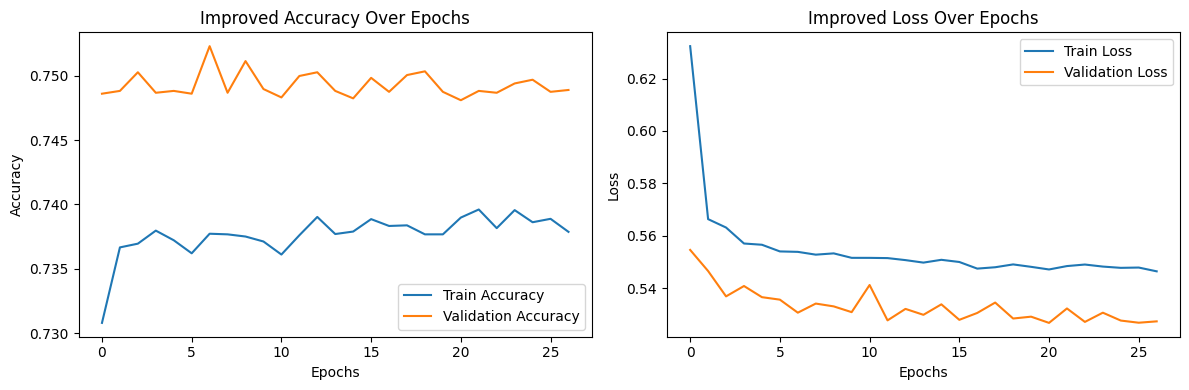

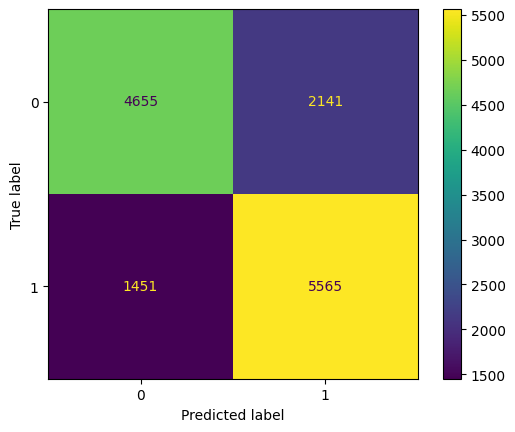

TP: 5565
FN: 1451
FP: 2141
TN: 4655
Diabetic Accuracy: 0.7932
Non-Diabetic Accuracy: 0.6850


In [87]:
# Evaluation
y_test_pred= model22.predict(X_test_scaled) > 0.5
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(model_fit22.history['accuracy'], label='Train Accuracy')
plt.plot(model_fit22.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Improved Accuracy Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(model_fit22.history['loss'], label='Train Loss')
plt.plot(model_fit22.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Improved Loss Over Epochs')

plt.tight_layout()
plt.show()

# Generate confusion matrix on the test set
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Print TP, FN, FP, TN
TP = cm[1, 1]
FN = cm[1, 0]
FP = cm[0, 1]
TN = cm[0, 0]

print("TP:", TP)
print("FN:", FN)
print("FP:", FP)
print("TN:", TN)

# Compute subgroup accuracy
diabetic_accuracy = TP / (TP + FN)
non_diabetic_accuracy = TN / (TN + FP)

print(f'Diabetic Accuracy: {diabetic_accuracy:.4f}')
print(f'Non-Diabetic Accuracy: {non_diabetic_accuracy:.4f}')
